In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
inspector = inspect(engine)
print(inspector.get_table_names())

['measurement', 'station']


In [7]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
sel=[Measurement.date]
latest=session.query(*sel).order_by(Measurement.date.desc()).first()[0]
print(f'Most Recent Date: {latest}')

Most Recent Date: 2017-08-23


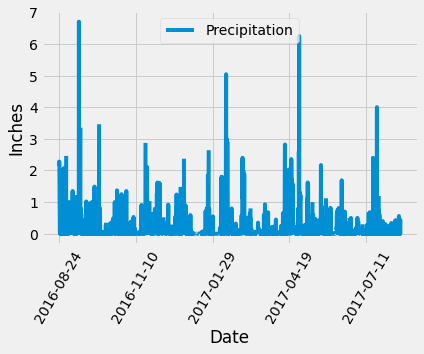

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date=dt.strptime(latest,'%Y-%m-%d')

# Calculate the date one year from the last date in data set.
year_ago=latest_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_query=session.query(Measurement.date, Measurement.prcp).filter(func.strftime("%Y-%m-%d",Measurement.date)>year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(year_query,columns=['Date', 'Precipitation']).set_index("Date")

# Sort the dataframe by date
df.sort_values(by=['Date'], inplace=True, ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(ylabel="Inches", rot=60)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(f"COUNT: {df['Precipitation'].count()}")
print(f"AVG: {df['Precipitation'].mean()}")
print(f"MEDIAN: {df['Precipitation'].median()}")
print(f"STDEV: {df['Precipitation'].std()}")
print(f"MIN: {df['Precipitation'].min()}")
print(f"MAX: {df['Precipitation'].max()}")

COUNT: 2015
AVG: 0.17646153846153845
MEDIAN: 0.02
STDEV: 0.46028836368132575
MIN: 0.0
MAX: 6.7


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
sel=[Station.station]
station_count=session.query(*sel).count()
print(f"Total Number of Stations: {station_count}")

Total Number of Stations: 9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel=[Measurement.station, Measurement.tobs]
station_active=session.query(*sel).all()
df=pd.DataFrame(station_active,columns=['Station','tobs']).groupby('Station').count().sort_values(by='tobs',ascending=False)
df

,tobs
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_id=(df.first_valid_index())
print(f'Most active station: {active_id}')
sel_min=[Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
station_active=session.query(*sel_min).filter_by(station=active_id)
active_df=pd.DataFrame(station_active,columns=['Station','Min','Max', 'Avg']).set_index('Station')
active_df

Most active station: USC00519281


,Min,Max,Avg
Station,,,
USC00519281,54.0,85.0,71.663781


Text(0.5, 0, 'Temperature')

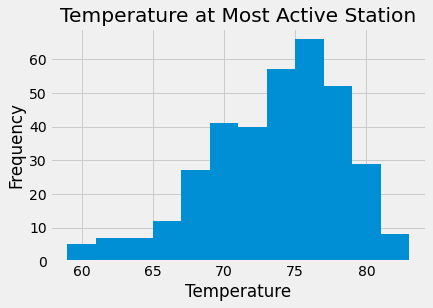

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel=[Measurement.station, Measurement.tobs]
station_active=session.query(*sel).filter_by(station=active_id)
year_query2=station_active.filter(func.strftime("%Y-%m-%d",Measurement.date)>year_ago).all()
df2=pd.DataFrame(year_query2,columns=['Station', 'tobs'])
hist=df2.hist(bins=12, legend=False)
plt.title('Temperature at Most Active Station')
plt.ylabel('Frequency')
plt.xlabel('Temperature')

# Close session

In [17]:
# Close Session
session.close()